# In Depth: Principal Component Analysis
Principal Component Analysis (PCA) is perhaps one of the most broadly used of unsupervised algorithms. PCA is fundamentally a dimensionality reduction algorithm, but it can also be useful as a tool for visualization, for noise filtering, for feature extraction and engineering, and much more.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Introducing PCA
PCA is a fast and flexible unsupervised method for dimensionality reduction in data. Its behavior is easiest to visualize by looking at a two-dimensional dataset. Consider the following:

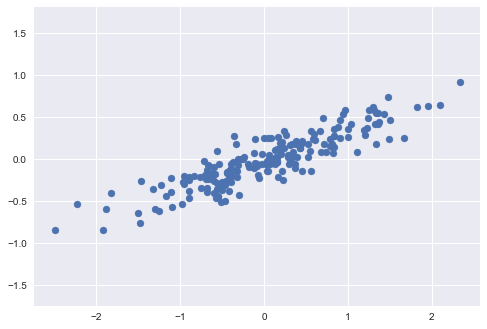

In [7]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:,0], X[:,1])
plt.axis('equal');

By eye, it's clear there is a nearly linear relationship between the x and y variables, similar to linear regression, but the problem setting here is slightly different: rather than attempting to predict the y values from the x values, the unsupervised learning problem attempts to learn about the relationship between x and y values. In PCA, one quantifies this relationship by finding a list of the *principal axes* in the data, and using those axes to describe the dataset. The fit learns some quantities from the data, most importantly the "components" and "explained variance". Here is an example with Scikit-Learn:

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [9]:
print pca.components_

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [10]:
print pca.explained_variance_

[ 0.75871884  0.01838551]


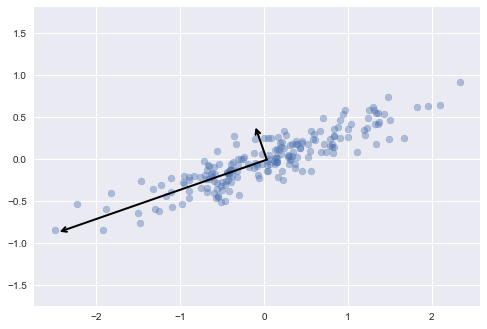

In [11]:
# Let's visualize these "components" to get a better understanding
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
    
# plot data
plt.scatter(X[:,0], X[:,1], alpha=0.4)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

These vectors represent the ***principal axes*** of the data, and the length is an indication of how "important" that axis is in describing the distribution of the data. More specifically, it is a measure of the variance of the data when projected onto that axis. The projection of each data point onto the pricipal axes are the "principal components" of the data. Here is a plot of the principal components alongside the original data:

![PCA](images/PCA_rotation.png)

This transformation from data axes to principal axes is as an *affine transformation*, which basically means it is composed of a translation, rotation, and uniform scaling.

#### PCA as dimensionality reduction
Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

In [12]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print "original shape: ", X.shape
print "transformed shape: ", X_pca.shape

original shape:  (200, 2)
transformed shape:  (200, 1)


The transformed data has been reduced to a single dimension. To understand this effect of this dimensionality reduction, we can perform the inverse transform of this reduced data and plot it along with the original data:

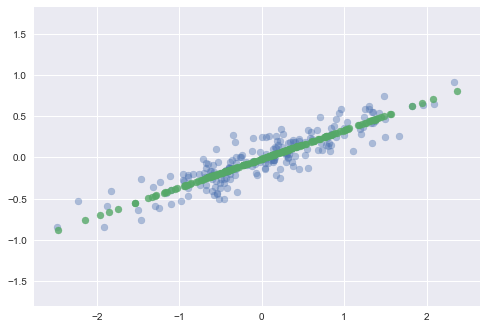

In [13]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.4)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha = 0.8)
plt.axis('equal');

The blue points are the original data, while the green points are the projected version. The information along the least important principal axis is removed, leaving only the component(s) of the data with the highest variance. The fraction of variance that is cut out is roughly a measure of how much "information" is discarded in this reduction of dimensionality.

This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points. Despite reducing the data by 50%, the overall relationship between the data points is mostly preserved.

#### PCA for visualization: Handwritten digits
Let's have a look at how PCA can be useful for datasets with most than two dimensions.

In [14]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

The handwritten digit dataset consists of 1797 8p x 8p images (64 pixels per image). Each pixel has a dedicated feature column. Let's use PCA to project the relationships of the data points into two dimensions:

In [15]:
pca = PCA(2) #project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print digits.data.shape
print projected.shape

(1797, 64)
(1797, 2)


/Volumes/RobStorage/anaconda2/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


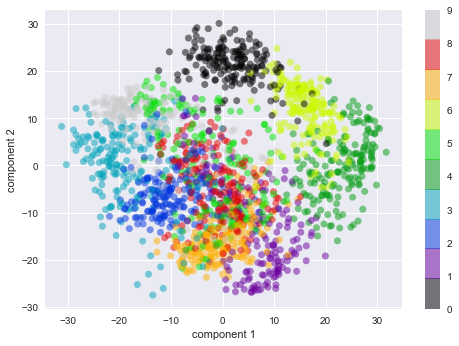

In [16]:
# plot the first two principal components of each point
plt.scatter(projected[:, 0], projected[:, 1], c=digits.target, edgecolor='none',
            alpha=0.5, cmap=plt.cm.get_cmap('spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

The full dataset is a 64-point cloud, and these points are the projection of each data point along the directions with the largest variance. Essentially, we have found the optimal stretch and rotation in 64-dimensional space that allows us to see the layout of the digits in two dimensions, and have done it in an unsupervised manner without any reference to labels.

#### What do the components mean?
Each image in the training set is defined by a collection of 64 pixel values, which we will call the vector *x*:

$x = [x_1,x_2,x_3...x_{64}]$

To construct the image, we multiply each element of the vector by the pixel it describes, and then add the results together to build the image:

$image(x) = x_1 * (pixel 1) + x_2 * (pixel 2) + x_3 * (pixel 3)... x_{64} * (pixel 64)$

One way to reduce the dimension of this data is to zero out all but a few of these basis vectors. For example, if we were use only the first eight pixels, we get an eight-dimensional projection of the data (see below), but this is not very reflective of the whole image because we have thrown out 90% of the data.

![digits](images/digits_pixel.png)

Fortunately the pixel-wise representation is not the only choice of basis. We can also use other basis functions which can contain some predefined contribution from each pixel:

$image(x) = mean + x_1 * (basis 1) + x_2 * (basis 2) + x_3 * (basis 3)...$

PCA can be thought of as a process of choosing optimal basis functions, such that adding together just the first few of them is enough to suitably reconstruct the bulk of the elements in the dataset. The principal components, which act as the low-dimensional representation of our data, are simply the coefficients that multiply each of the elements in this series. Below is a depiction of reconstructing this digit using the mean plus the first eight PCA basis functions:

![digits pca](images/digits_pca.png)

The PCA basis allows us to recover the major features of the input image with just a mean plus eight components! The amount of each pixel in each component is the corollary of the orientation of the vector in our two-dimensional example. PCA provides a low-dimensional representation of the data by discovering a set of basis functions that are more efficient than the native pixel-basis of the input data.

#### Choosing the number of components
A vital part of using PCA is the ability to estimate how many components are needed to describe the data. We can determine this by looking at the cumulative *explained variance ratio* as a function of the number of components.

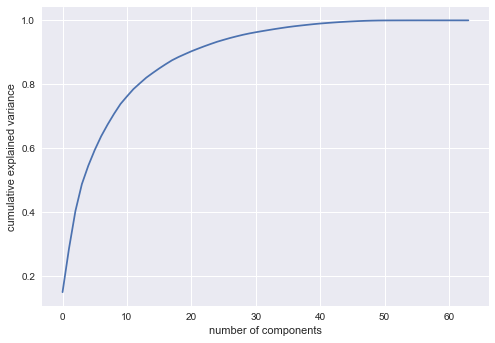

In [18]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This curve quantifies how much of the 64-dimensional variance is contained within the first N components. The first 10 components capture roughly 80% of the variance, and you would need around 50 components to measure 100% variance.

## PCA as Noise Filtering
PCA can also be used as a filtering approach for noisy data. Any components with variance much larger than the effect of the noise should be relatively unaffected by the noise. If you reconstruct the data using just the largest subset of principal components, you should be preferentially keeping the signal and tossing the noise.

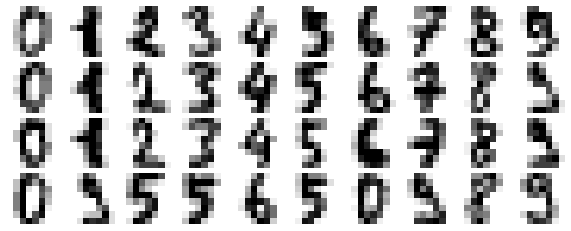

In [19]:
# DIGITS WITHOUT NOISE

def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest', clim=(0, 16))
        
plot_digits(digits.data)

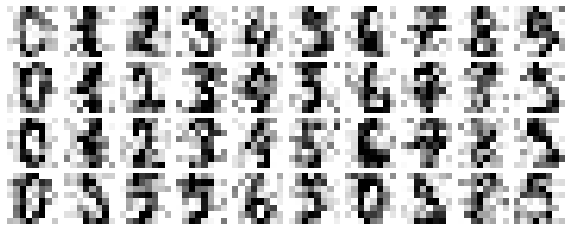

In [20]:
# DIGITS WITH NOISE
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

Now let's train a PCA on the noisy data, requesting that the projection preserve 50% of the variance. 50% of the variance amounts to 12 principal components. Now we compute these components and use the inverse of the transform to reconstruct the filtered digits.

In [21]:
pca = PCA(0.5).fit(noisy)
pca.n_components_

12

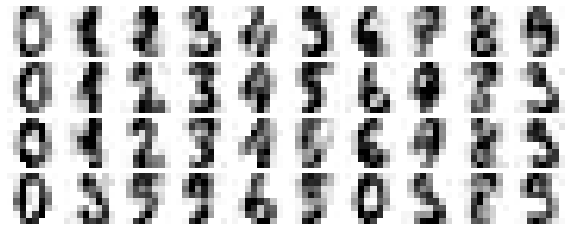

In [23]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

This signal preserving/noise filtering property makes PCA a very useful feature selection routine. For example, instead of training a classifier on very high-dimensional data, you might instead train the classifier on the lower-dimensional representation, which will automatically serve to filter out random noise in the inputs.

## Example: Eigenfaces

In [24]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print faces.target_names
print faces.images.shape

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


We have 1348 images of world leaders. Each image is 64 x 47 pixels (3008 pixels per image). Because this is a large dataset, we will use `RandomizedPCA` because it contains a randomized method to approximate the first N principal components much more quickly than the standard PCA estimator. Let's take a look at the first 150 components (reducing the data by roughly 95%!).

In [26]:
from sklearn.decomposition import RandomizedPCA
pca = RandomizedPCA(150)
pca.fit(faces.data)

/Volumes/RobStorage/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


RandomizedPCA(copy=True, iterated_power=2, n_components=150,
       random_state=None, whiten=False)

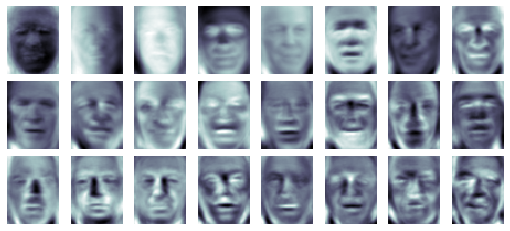

In [27]:
# visualize the images associated with the first several principal components (eigenvectors)
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62,47), cmap='bone')

The first few eigenfaces (top left) seem to be associated with the angle of lighting on the face, and later principal vectors seem to be pickout out certain features, such as eyes, noses, and lips. Let's see the cumulative variance of these components to see how much of the data information the projection is preserving:

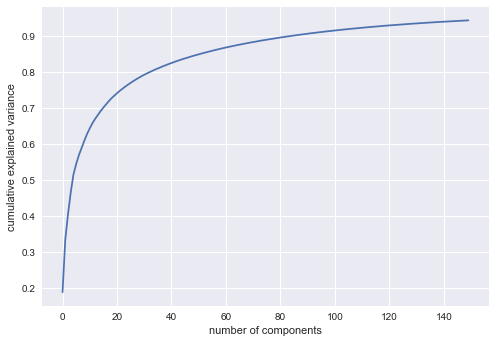

In [28]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

We see that 150 components account for over 90% of the variance. That would lead us to believe that we can recover most of the essential characteristics of the data with these 150 components. To let this idea sink in even better, let's compare the input images with the images reconstructed from the 150 components.

In [29]:
# Compute the components and projected faces
pca = RandomizedPCA(150).fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

/Volumes/RobStorage/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


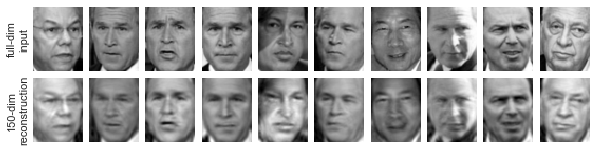

In [31]:
# plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62,47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62,47), cmap='binary_r')
    
ax[0,0].set_ylabel('full-dim\ninput')
ax[1,0].set_ylabel('150-dim\nreconstruction');

The top row shows the input images while the bottom row shows the reconstruction of the images from just 150 of the possible 3008 initial features. Although PCA reduces the dimensionality of the data by 95%, the projected images contain enough information that we might, by eye, recognize the individuals in the image.

## PCA Summary
Because of the versatility and interpretability of PCA, it has been shown to be effective in a wide variety of contexts and disciplines. PCA is a very useful starting point when given a high-dimensional dataset, because it allows one to visualize the relationship between points, understand the main variance in the data, and understand the intrinsic dimensionality.

PCA's main weakness is that it tends to be highly affected by outliers in the data. For this reason, many robust variants of PCA have been developed, many of which act to iteratively discard data points that are poorly decribed by the initial components.